背景：
通过过去的10分钟订单簿数据和交易数据，预测接下来10分钟的股票波动率
112支股票，3830个时间窗口，414287个目标波动率，每个时间窗口有600个意向数据(理想情况下，目前平均每个时间窗口有400多个意向数据)
每个时间窗口有600个交易数据(理想情况下，目前平均每个时间窗口有80多个交易数据)

1、做了什么工作？

2、怎么实现的？

3、为什么这么做？

4、要是自己自己会怎么做？

5、有哪些工作是可以应用到后续的实践中的？

112支股票的time_id都是一致的

In [1]:
import gc
import glob
import os
import time
import traceback
from contextlib import contextmanager
from enum import Enum
from typing import Dict, List, Optional, Tuple

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from IPython.display import display

from joblib import delayed, Parallel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale
from tqdm import tqdm_notebook as tqdm


%matplotlib inline

DATA_DIR = '../input'

# data configurations
USE_PRECOMPUTE_FEATURES = True  
# Load precomputed features for train.csv from private dataset (just for speed up)

# model & ensemble configurations
PREDICT_CNN = True
PREDICT_MLP = True
PREDICT_GBDT = True
PREDICT_TABNET = False

GBDT_NUM_MODELS = 5 #3
GBDT_LR = 0.02  # 0.1

NN_VALID_TH = 0.185
NN_MODEL_TOP_N = 3
TAB_MODEL_TOP_N = 3
ENSEMBLE_METHOD = 'mean'
NN_NUM_MODELS = 10
TABNET_NUM_MODELS = 5

# for saving quota
IS_1ST_STAGE = False
SHORTCUT_NN_IN_1ST_STAGE = False  # early-stop training to save GPU quota
SHORTCUT_GBDT_IN_1ST_STAGE = False
MEMORY_TEST_MODE = False

# for ablation studies
CV_SPLIT = 'time'  # 'time': time-series KFold 'group': GroupKFold by stock-id
USE_PRICE_NN_FEATURES = True  # Use nearest neighbor features that rely on tick size
USE_VOL_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_SIZE_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_RANDOM_NN_FEATURES = False  # Use random index to aggregate neighbors

USE_TIME_ID_NN = True  # Use time-id based neighbors
USE_STOCK_ID_NN = True  # Use stock-id based neighbors

ENABLE_RANK_NORMALIZATION = True  # Enable rank-normalization


@contextmanager
def timer(name: str):
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f'[{name}] {elapsed: .3f}sec')
    
def print_trace(name: str = ''):
    print(f'ERROR RAISED IN {name or "anonymous"}')
    print(traceback.format_exc())

In [2]:
!pip -q install ../input/pytorchtabnet/pytorch_tabnet-2.0.1-py3-none-any.whl

In [3]:
train = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'train.csv'))
stock_ids = set(train['stock_id'])

没有缺失值，数据质量很高，原始数据共有13个特征：

实际交易数据里面包含4个：具体交易时间、交易价格、交易数量、
交易订单数量

交易意向数据里面有9个特征，最具竞争力的第一第二买卖价格、数量、具体发生的时间。

## Feature Engineering

### Base Features

book_train特征数量49个，四个时间窗口：150/300/450/600s

trade_train特征数量4个，四个时间窗口：150/300/450/600s

共计49+4=53*4=212个

每只股票每个时间窗口都有一个最小的价格刻度，

基础特征构造阶段一共有213个特征，实际是54个，不过是53个特征

多加了几个时间窗口

In [4]:
class DataBlock(Enum):
    TRAIN = 1
    TEST = 2
    BOTH = 3


def load_stock_data(stock_id: int, directory: str) -> pd.DataFrame:
    return pd.read_parquet(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 
                                        directory, f'stock_id={stock_id}'))


def load_data(stock_id: int, stem: str, block: DataBlock) -> pd.DataFrame:
    if block == DataBlock.TRAIN:
        return load_stock_data(stock_id, f'{stem}_train.parquet')
    elif block == DataBlock.TEST:
        return load_stock_data(stock_id, f'{stem}_test.parquet')
    else:
        return pd.concat([
            load_data(stock_id, stem, DataBlock.TRAIN),
            load_data(stock_id, stem, DataBlock.TEST)
        ]).reset_index(drop=True)

def load_book(stock_id: int, block: DataBlock=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'book', block)


def load_trade(stock_id: int, block=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'trade', block)


def calc_wap1(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price1'] * df['ask_size1'] + 
           df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap


def calc_wap2(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price2'] * df['ask_size2'] + 
           df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap


def realized_volatility(series):
    return np.sqrt(np.sum(series**2))


def log_return(series: np.ndarray):
    return np.log(series).diff()


def log_return_df2(series: np.ndarray):
    return np.log(series).diff(2)



def flatten_name(prefix, src_names):
    ret = []
    for c in src_names:
        if c[0] in ['time_id', 'stock_id']:
            ret.append(c[0])
        else:
            ret.append('.'.join([prefix] + list(c)))
    return ret


#订单簿数据特征构造
def make_book_feature(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)
    #使用买卖双方的最好价格和数量来计算加权平均价格
    book['wap1'] = calc_wap1(book)
    #使用买卖双方的第二好价格和数量来计算加权平均价格
    book['wap2'] = calc_wap2(book)
    #计算对数回报
    book['log_return1'] = book.groupby(['time_id'])['wap1'].apply(log_return)
    book['log_return2'] = book.groupby(['time_id'])['wap2'].apply(log_return)
    #直接使用买卖双方的价格计算对数回报
    book['log_return_ask1'] = book.groupby(['time_id'])['ask_price1'].apply(log_return)
    book['log_return_ask2'] = book.groupby(['time_id'])['ask_price2'].apply(log_return)
    book['log_return_bid1'] = book.groupby(['time_id'])['bid_price1'].apply(log_return)
    book['log_return_bid2'] = book.groupby(['time_id'])['bid_price2'].apply(log_return)
    #加权平均价格的差异大小
    book['wap_balance'] = abs(book['wap1'] - book['wap2'])
    #买卖差价
    book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / ((book['ask_price1']
                                                                         + book['bid_price1']) / 2)
    book['bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['ask_spread'] = book['ask_price1'] - book['ask_price2']
    #买卖股票数量
    book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + 
    (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] 
                                                                              + book['bid_size2']))
    #聚合统计特征
    features = {
        'seconds_in_bucket': ['count'],
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }
    
    agg = book.groupby('time_id').agg(features).reset_index(drop=False)
    agg.columns = flatten_name('book', agg.columns)
    agg['stock_id'] = stock_id
    
    #构造450/300/150秒区间内的
    for time in [450, 300, 150]:
        d = book[book['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'book_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    return agg

#交易数据特征构造
def make_trade_feature(stock_id, block = DataBlock.TRAIN):
    trade = load_trade(stock_id, block)
    trade['log_return'] = trade.groupby('time_id')['price'].apply(log_return)

    features = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':['count'],
        'size':[np.sum],
        'order_count':[np.mean],
    }

    agg = trade.groupby('time_id').agg(features).reset_index()
    agg.columns = flatten_name('trade', agg.columns)
    agg['stock_id'] = stock_id
        
    for time in [450, 300, 150]:
        d = trade[trade['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'trade_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    return agg

#求解每个时间窗口的最小价格刻度
def make_book_feature_v2(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)

    prices = book.set_index('time_id')[['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']]
    time_ids = list(set(prices.index))

    ticks = {}
    for tid in time_ids:
        try:
            price_list = prices.loc[tid].values.flatten()
            price_diff = sorted(np.diff(sorted(set(price_list))))
            ticks[tid] = price_diff[0]
        except Exception:
            print_trace(f'tid={tid}')
            ticks[tid] = np.nan
        
    dst = pd.DataFrame()
    dst['time_id'] = np.unique(book['time_id'])
    dst['stock_id'] = stock_id
    dst['tick_size'] = dst['time_id'].map(ticks)

    return dst

#生成构造特征的函数
def make_features(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature)(i, block) for i in stock_ids)
        book = pd.concat(books)

    with timer('trades'):
        trades = Parallel(n_jobs=-1)(delayed(make_trade_feature)(i, block) for i in stock_ids)
        trade = pd.concat(trades)

    with timer('extra features'):
        df = pd.merge(base, book, on=['stock_id', 'time_id'], how='left')
        df = pd.merge(df, trade, on=['stock_id', 'time_id'], how='left')
        #df = make_extra_features(df)

    return df

#把求解的最小价格刻度添加到元数据中
def make_features_v2(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books(v2)'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature_v2)(i, block) for i in stock_ids)
        book_v2 = pd.concat(books)

    d = pd.merge(base, book_v2, on=['stock_id', 'time_id'], how='left')
    return d

In [5]:
#执行生成基础特征的函数，并将train数据和book/trade的数据合并
if USE_PRECOMPUTE_FEATURES:
    with timer('load feather'):
        df = pd.read_feather(os.path.join(DATA_DIR, 'optiver-df2', 'features_v2.f'))
else:
    df = make_features(train, DataBlock.TRAIN)
    # v2
    df = make_features_v2(df, DataBlock.TRAIN)

df.to_feather('features_v2.f')  # save cache



test = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'test.csv'))
if len(test) == 3:
    print('is 1st stage')
    IS_1ST_STAGE = True

if IS_1ST_STAGE and MEMORY_TEST_MODE:
    print('use copy of training data as test data to immitate 2nd stage RAM usage.')
    test_df = df.iloc[:170000].copy()
    test_df['time_id'] += 32767
    test_df['row_id'] = ''
else:
    test_df = make_features(test, DataBlock.TEST)
    test_df = make_features_v2(test_df, DataBlock.TEST)

print(df.shape)
print(test_df.shape)
df = pd.concat([df, test_df.drop('row_id', axis=1)]).reset_index(drop=True)

[load feather]  7.129sec
is 1st stage
[books]  1.156sec
[trades]  0.336sec
[extra features]  0.062sec
[books(v2)]  0.065sec
(428932, 216)
(3, 216)


### Nearest-Neighbor Features

In [6]:
N_NEIGHBORS_MAX = 80

class Neighbors:
    def __init__(self, 
                 name: str, 
                 pivot: pd.DataFrame, 
                 p: float, 
                 metric: str = 'minkowski', 
                 metric_params: Optional[Dict] = None, 
                 exclude_self: bool = False):
        self.name = name
        self.exclude_self = exclude_self
        self.p = p
        self.metric = metric
        
        if metric == 'random':
            n_queries = len(pivot)
            self.neighbors = np.random.randint(n_queries, size=(n_queries, N_NEIGHBORS_MAX))
        else:
            nn = NearestNeighbors(
                n_neighbors=N_NEIGHBORS_MAX, 
                p=p, 
                metric=metric, 
                metric_params=metric_params
            )
            nn.fit(pivot)
            _, self.neighbors = nn.kneighbors(pivot, return_distance=True)

        self.columns = self.index = self.feature_values = self.feature_col = None

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        raise NotImplementedError()

    #构造近邻股票/时间窗口的特征
    def make_nn_feature(self, n=5, agg=np.mean) -> pd.DataFrame:
        assert self.feature_values is not None, "should call rearrange_feature_values beforehand"

        start = 1 if self.exclude_self else 0

        pivot_aggs = pd.DataFrame(
            agg(self.feature_values[start:n,:,:], axis=0), 
            columns=self.columns, 
            index=self.index
        )

        dst = pivot_aggs.unstack().reset_index()
        dst.columns = ['stock_id', 'time_id', f'{self.feature_col}_nn{n}_{self.name}_{agg.__name__}']
        return dst


class TimeIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())
        feature_pivot.head()

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[self.neighbors[:, i], :]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col
        
    def __repr__(self) -> str:
        return f"time-id NN (name={self.name}, metric={self.metric}, p={self.p})"


class StockIdNeighbors(Neighbors):
    #构造近似股票的数据
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        """stock-id based nearest neighbor features"""
        feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[:, self.neighbors[:, i]]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col
        
    def __repr__(self) -> str:
        return f"stock-id NN (name={self.name}, metric={self.metric}, p={self.p})"


In [7]:
# the tau itself is meaningless for GBDT, but useful as input to aggregate in Nearest Neighbor features
#tau 本身对 GBDT 没有意义，但可用作聚合最近邻特征的输入
df['trade.tau'] = np.sqrt(1 / df['trade.seconds_in_bucket.count'])
df['trade_150.tau'] = np.sqrt(1 / df['trade_150.seconds_in_bucket.count'])
df['book.tau'] = np.sqrt(1 / df['book.seconds_in_bucket.count'])
df['real_price'] = 0.01 / df['tick_size']

#### Build Nearest Neighbors

In [8]:
time_id_neighbors: List[Neighbors] = []
stock_id_neighbors: List[Neighbors] = []

with timer('knn fit'):
    df_pv = df[['stock_id', 'time_id']].copy()
    df_pv['price'] = 0.01 / df['tick_size']
    df_pv['vol'] = df['book.log_return1.realized_volatility']
    df_pv['trade.tau'] = df['trade.tau']
    df_pv['trade.size.sum'] = df['book.total_volume.sum']

    if USE_PRICE_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'price')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_c', 
                pivot, 
                p=2, 
                metric='canberra', 
                exclude_self=True
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_m', 
                pivot, 
                p=2, 
                metric='mahalanobis',
                metric_params={'V':np.cov(pivot.values.T)}
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_price_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True)
        )

    if USE_VOL_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors('time_vol_l1', pivot, p=1)
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_vol_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True
            )
        )

    if USE_SIZE_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'trade.size.sum')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_m', 
                pivot, 
                p=2, 
                metric='mahalanobis', 
                metric_params={'V':np.cov(pivot.values.T)}
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_c', 
                pivot, 
                p=2, 
                metric='canberra'
            )
        )
        
    if USE_RANDOM_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_random', 
                pivot, 
                p=2, 
                metric='random'
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_random', 
                pivot.transpose(), 
                p=2,
                metric='random')
        )


if not USE_TIME_ID_NN:
    time_id_neighbors = []
    
if not USE_STOCK_ID_NN:
    stock_id_neighbors = []

[knn fit]  410.800sec


#### Check Neighbor Indices

In [9]:
def calculate_rank_correraltion(neighbors, top_n=5):
    if not neighbors:
        return
    neighbor_indices = pd.DataFrame()
    for n in neighbors:
        neighbor_indices[n.name] = n.neighbors[:,:top_n].flatten()

    sns.heatmap(neighbor_indices.corr('kendall'), annot=True)

In [10]:
time_ids = np.array(sorted(df['time_id'].unique()))
for neighbor in time_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            time_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(time_ids, name='time_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).iloc[1:6]
    )

time-id NN (name=time_price_c, metric=canberra, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,30183,31471,26708,7864,22752,10619,11453,1205,9352
11,11,2811,29583,30798,17639,25131,23202,14857,4739,3399
16,16,5829,4275,7783,4487,7845,25439,17530,18634,19747
31,31,6367,19386,1255,12559,19472,18358,31719,6481,26475
32,34,32,4,31554,24443,5916,19164,20430,659,31077


time-id NN (name=time_price_m, metric=mahalanobis, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,30183,31471,26708,1205,22752,10619,9352,7864,11453
11,11,2811,29583,30798,17639,23202,25131,14857,4739,28020
16,16,5829,4487,7783,25439,17530,7845,4275,32590,18634
31,31,6367,19386,12559,1255,22519,19472,31719,6481,18358
32,34,32,4,19230,17460,4913,14311,20597,20935,3046


time-id NN (name=time_vol_l1, metric=minkowski, p=1)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,9352,15276,13791,1205,12923,26708,2331,2136,10672
11,11,23202,30798,17639,7460,29583,11227,2811,25131,32597
16,16,9060,25179,25439,21777,15727,17530,6476,211,30791
31,31,10291,15689,18848,22824,14449,1142,6367,21148,25731
32,32,34,4,25584,26883,5235,2772,26430,2502,22014


time-id NN (name=time_size_m, metric=mahalanobis, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,26708,22752,30183,32,34,9352,27014,1205,4
11,11,29583,2811,14857,17639,32,34,11682,13513,4739
16,16,15352,5829,13775,11869,10364,15491,1797,7783,32
31,31,6367,31719,32,34,18358,12559,19472,22519,31522
32,34,32,4,31004,16649,1161,611,13586,23967,20410


time-id NN (name=time_size_c, metric=canberra, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,26708,30183,22752,1205,10619,9352,15276,30620,2683
11,11,2811,17639,29583,25131,28020,17604,9822,4739,30798
16,16,5829,4487,6121,7783,1040,29026,7845,17530,16118
31,31,6367,12559,22519,18358,7897,19472,31522,19386,31719
32,34,32,4,15989,11985,3732,26430,3607,10523,4487


In [11]:
stock_ids = np.array(sorted(df['stock_id'].unique()))
for neighbor in stock_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            stock_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(stock_ids, name='stock_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).loc[64]
    )

stock-id NN (name=stock_price_l1, metric=minkowski, p=1)


top_1      64
top_2      53
top_3      56
top_4     124
top_5      73
top_6      96
top_7      30
top_8      28
top_9      66
top_10     33
Name: 64, dtype: int64

stock-id NN (name=stock_vol_l1, metric=minkowski, p=1)


top_1      64
top_2      20
top_3      93
top_4      67
top_5      52
top_6     107
top_7      70
top_8     120
top_9     102
top_10     39
Name: 64, dtype: int64

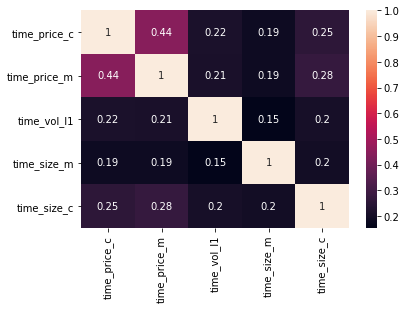

In [12]:
calculate_rank_correraltion(time_id_neighbors)

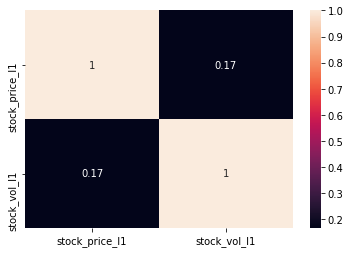

In [13]:
calculate_rank_correraltion(stock_id_neighbors)

#### Aggregate Features With Neighbors

In [14]:
# features with large changes over time are converted to relative ranks within time-id
# 随时间变化较大的特征将转换为time-id内的相对等级
if ENABLE_RANK_NORMALIZATION:
    df['trade.order_count.mean'] = df.groupby('time_id')['trade.order_count.mean'].rank()
    df['book.total_volume.sum']  = df.groupby('time_id')['book.total_volume.sum'].rank()
    df['book.total_volume.mean'] = df.groupby('time_id')['book.total_volume.mean'].rank()
    df['book.total_volume.std']  = df.groupby('time_id')['book.total_volume.std'].rank()

    df['trade.tau'] = df.groupby('time_id')['trade.tau'].rank()

    for dt in [150, 300, 450]:
        df[f'book_{dt}.total_volume.sum']  = df.groupby('time_id')[f'book_{dt}.total_volume.sum'].rank()
        df[f'book_{dt}.total_volume.mean'] = df.groupby('time_id')[f'book_{dt}.total_volume.mean'].rank()
        df[f'book_{dt}.total_volume.std']  = df.groupby('time_id')[f'book_{dt}.total_volume.std'].rank()
        df[f'trade_{dt}.order_count.mean'] = df.groupby('time_id')[f'trade_{dt}.order_count.mean'].rank()

In [15]:
def make_nearest_neighbor_feature(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    print(df2.shape)

    feature_cols_stock = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade_150.tau': [np.mean],
        'book.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
    }
    
    feature_cols = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'real_price': [np.max, np.mean, np.min],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
        'trade_150.tau_nn20_stock_vol_l1_mean': [np.mean],
        'trade.size.sum_nn20_stock_vol_l1_mean': [np.mean],
    }

    time_id_neigbor_sizes = [3, 5, 10, 20, 40]
    time_id_neigbor_sizes_vol = [2, 3, 5, 10, 20, 40]
    stock_id_neighbor_sizes = [10, 20, 40]

    ndf: Optional[pd.DataFrame] = None

    def _add_ndf(ndf: Optional[pd.DataFrame], dst: pd.DataFrame) -> pd.DataFrame:
        if ndf is None:
            return dst
        else:
            ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
            return ndf

    # neighbor stock_id
    for feature_col in feature_cols_stock.keys():
        try:
            if feature_col not in df2.columns:
                print(f"column {feature_col} is skipped")
                continue

            if not stock_id_neighbors:
                continue
            
            #对于每一个最近邻的股票，构造特征
            for nn in stock_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            for agg in feature_cols_stock[feature_col]:
                for n in stock_id_neighbor_sizes:
                    try:
                        for nn in stock_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            ndf = _add_ndf(ndf, dst)
                    except Exception:
                        print_trace('stock-id nn')
                        pass
        except Exception:
            print_trace('stock-id nn')
            pass

    if ndf is not None:
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')
    ndf = None

    print(df2.shape)

    # neighbor time_id
    for feature_col in feature_cols.keys():
        try:
            if not USE_PRICE_NN_FEATURES and feature_col == 'real_price':
                continue
            if feature_col not in df2.columns:
                print(f"column {feature_col} is skipped")
                continue

            for nn in time_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            if 'volatility' in feature_col:
                time_id_ns = time_id_neigbor_sizes_vol
            else:
                time_id_ns = time_id_neigbor_sizes

            for agg in feature_cols[feature_col]:
                for n in time_id_ns:
                    try:
                        for nn in time_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            ndf = _add_ndf(ndf, dst)
                    except Exception:
                        print_trace('time-id nn')
                        pass
        except Exception:
            print_trace('time-id nn')

    if ndf is not None:
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')

    # features further derived from nearest neighbor features
    # 从最近邻特征进一步派生的特征
    try:
        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neigbor_sizes:
                denominator = f"real_price_nn{sz}_time_price_c"

                df2[f'real_price_rankmin_{sz}']  = df2['real_price'] / df2[f"{denominator}_amin"]
                df2[f'real_price_rankmax_{sz}']  = df2['real_price'] / df2[f"{denominator}_amax"]
                df2[f'real_price_rankmean_{sz}'] = df2['real_price'] / df2[f"{denominator}_mean"]

            for sz in time_id_neigbor_sizes_vol:
                denominator = f"book.log_return1.realized_volatility_nn{sz}_time_price_c"

                df2[f'vol_rankmin_{sz}'] = \
                    df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_amin"]
                df2[f'vol_rankmax_{sz}'] = \
                    df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_amax"]

        price_cols = [c for c in df2.columns if 'real_price' in c and 'rank' not in c]
        for c in price_cols:
            del df2[c]

        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neigbor_sizes_vol:
                tgt = f'book.log_return1.realized_volatility_nn{sz}_time_price_m_mean'
                df2[f'{tgt}_rank'] = df2.groupby('time_id')[tgt].rank()
    except Exception:
        print_trace('nn features')

    return df2

In [16]:
gc.collect()

with timer('make nearest neighbor feature'):
    df2 = make_nearest_neighbor_feature(df)

print(df2.shape)
df2.reset_index(drop=True).to_feather('optiver_df2.f')

gc.collect()

(428935, 220)
(428935, 280)
[make nearest neighbor feature]  70.391sec
(428935, 582)


0

### Misc Features

杂项功能

In [17]:
# skew correction for NN
# 最近邻特征的偏斜矫正
cols_to_log = [
    'trade.size.sum',
    'trade_150.size.sum',
    'trade_300.size.sum',
    'trade_450.size.sum',
    'volume_imbalance'
]
for c in df2.columns:
    for check in cols_to_log:
        try:
            if check in c:
                df2[c] = np.log(df2[c]+1)
                break
        except Exception:
            print_trace('log1p')

In [18]:
# Rolling average of RV for similar trading volume
#求解相似交易量的滚动平均值
try:
    df2.sort_values(by=['stock_id', 'book.total_volume.sum'], inplace=True)
    df2.reset_index(drop=True, inplace=True)
    
    roll_target = 'book.log_return1.realized_volatility'

    for window_size in [3, 10]:
        df2[f'realized_volatility_roll{window_size}_by_book.total_volume.mean'] = \
            df2.groupby('stock_id')[roll_target].rolling(window_size, center=True, min_periods=1) \
                                                .mean() \
                                                .reset_index() \
                                                .sort_values(by=['level_1'])[roll_target].values
except Exception:
    print_trace('mean RV')

In [19]:
# stock-id embedding (helps little)
#stock-id 嵌入（帮助不大）
try:
    lda_n = 3
    lda = LatentDirichletAllocation(n_components=lda_n, random_state=0)

    stock_id_emb = pd.DataFrame(
        lda.fit_transform(pivot.transpose()), 
        index=df_pv.pivot('time_id', 'stock_id', 'vol').columns
    )

    for i in range(lda_n):
        df2[f'stock_id_emb{i}'] = df2['stock_id'].map(stock_id_emb[i])
except Exception:
    print_trace('LDA')

In [20]:
df_train = df2[~df2.target.isnull()].copy()
df_test = df2[df2.target.isnull()].copy()
del df2, df_pv
gc.collect()

88

## Reverse Engineering time-id Order & Make CV Split

时间顺序的逆向工程以及交叉验证的分割操作

In [21]:
%matplotlib inline

@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")
    

def calc_price2(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick


def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1',
                                               'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.set_index('time_id')
    df = df.groupby(level='time_id').apply(calc_price2).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df


def sort_manifold(df, clf):
    df_ = df.set_index('time_id')
    df_ = pd.DataFrame(minmax_scale(df_.fillna(df_.mean())))

    X_compoents = clf.fit_transform(df_)

    dft = df.reindex(np.argsort(X_compoents[:,0])).reset_index(drop=True)
    return np.argsort(X_compoents[:, 0]), X_compoents


def reconstruct_time_id_order():
    with timer('load files'):
        df_files = pd.DataFrame(
            {'book_path': glob.glob('/kaggle/input/ \
                                    optiver-realized-volatility-prediction/book_train.parquet/**/*.parquet')}) \
            .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')

    with timer('calc prices'):
        df_prices = pd.concat(Parallel(n_jobs=4, verbose=51) \
                              (delayed(calc_prices)(r) for _, r in df_files.iterrows()))
        df_prices = df_prices.pivot('time_id', 'stock_id', 'price')
        df_prices.columns = [f'stock_id={i}' for i in df_prices.columns]
        df_prices = df_prices.reset_index(drop=False)

    with timer('t-SNE(400) -> 50'):
        clf = TSNE(n_components=1, perplexity=400, random_state=0, n_iter=2000)
        order, X_compoents = sort_manifold(df_prices, clf)

        clf = TSNE(n_components=1, perplexity=50, random_state=0, 
                   init=X_compoents, n_iter=2000, method='exact')
        order, X_compoents = sort_manifold(df_prices, clf)

        df_ordered = df_prices.reindex(order).reset_index(drop=True)
        if df_ordered['stock_id=61'].iloc[0] > df_ordered['stock_id=61'].iloc[-1]:
            df_ordered = df_ordered.reindex(df_ordered.index[::-1]).reset_index(drop=True)

    # AMZN
    plt.plot(df_ordered['stock_id=61'])
    
    return df_ordered[['time_id']]

In [22]:
if CV_SPLIT == 'time':
    with timer('calculate order of time-id'):
        if USE_PRECOMPUTE_FEATURES:
            timeid_order = pd.read_csv(os.path.join(DATA_DIR, 'optiver-time-id-ordered', 'time_id_order.csv'))
        else:
            timeid_order = reconstruct_time_id_order()
    #按照时间划分交叉验证集
    with timer('make folds'):
        timeid_order['time_id_order'] = np.arange(len(timeid_order))
        df_train['time_id_order'] = df_train['time_id'].map(timeid_order.set_index('time_id')['time_id_order'])
        df_train = df_train.sort_values(['time_id_order', 'stock_id']).reset_index(drop=True)

        folds_border = [3830 - 383*4, 3830 - 383*3, 3830 - 383*2, 3830 - 383*1]
        time_id_orders = df_train['time_id_order']

        folds = []
        for i, border in enumerate(folds_border):
            idx_train = np.where(time_id_orders < border)[0]
            idx_valid = np.where((border <= time_id_orders) & (time_id_orders < border + 383))[0]
            folds.append((idx_train, idx_valid))

            print(f"folds{i}: train={len(idx_train)}, valid={len(idx_valid)}")

    del df_train['time_id_order']

#按照标签time_id分组进行交叉验证
elif CV_SPLIT == 'group':
    gkf = GroupKFold(n_splits=4)
    folds = []

    for i, (idx_train, idx_valid) in enumerate(gkf.split(df_train, None, groups=df_train['time_id'])):
        folds.append((idx_train, idx_valid))
else:
    raise ValueError()

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

[calculate order of time-id] 0.013sec
folds0: train=257362, valid=42882
folds1: train=300244, valid=42896
folds2: train=343140, valid=42896
folds3: train=386036, valid=42896
[make folds] 1.911sec


## LightGBM Training

In [23]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False


# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(cvbooster, figsize=(10, 10)):
    raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = cvbooster.boosters[0].feature_name()
    importance_df = pd.DataFrame(data=raw_importances,
                                 columns=feature_name)
    # order by average importance across folds
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # plot top-n
    PLOT_TOP_N = 50
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()


def get_X(df_src):
    cols = [c for c in df_src.columns if c not in ['time_id', 'target', 'tick_size']]
    return df_src[cols]


class EnsembleModel:
    def __init__(self, models: List[lgb.Booster], weights: Optional[List[float]] = None):
        self.models = models
        self.weights = weights

        features = list(self.models[0].feature_name())

        for m in self.models[1:]:
            assert features == list(m.feature_name())

    def predict(self, x):
        predicted = np.zeros((len(x), len(self.models)))

        for i, m in enumerate(self.models):
            w = self.weights[i] if self.weights is not None else 1
            predicted[:, i] = w * m.predict(x)

        ttl = np.sum(self.weights) if self.weights is not None else len(self.models)
        return np.sum(predicted, axis=1) / ttl

    def feature_name(self) -> List[str]:
        return self.models[0].feature_name()

(428932, 584)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.282080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.430224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.019611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.237943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[20]	cv_agg's l2: 7.38695e-07 + 1.60608e-07	cv_agg's RMSPE: 0.38011 + 0.0099775
[40]	cv_agg's l2: 4.52578e-07 + 8.38512e-08	cv_agg's RMSPE: 0.298445 + 0.00437991
[60]	cv_agg's l2: 3.23178e-07 + 5.03378e-08	cv_agg's RMSPE: 0.252918 + 0.00585063
[80]	cv_agg's l2: 2.63681e-07 + 3.6223e-08	cv_agg's RMSPE: 0.22891 + 0.00863284
[1

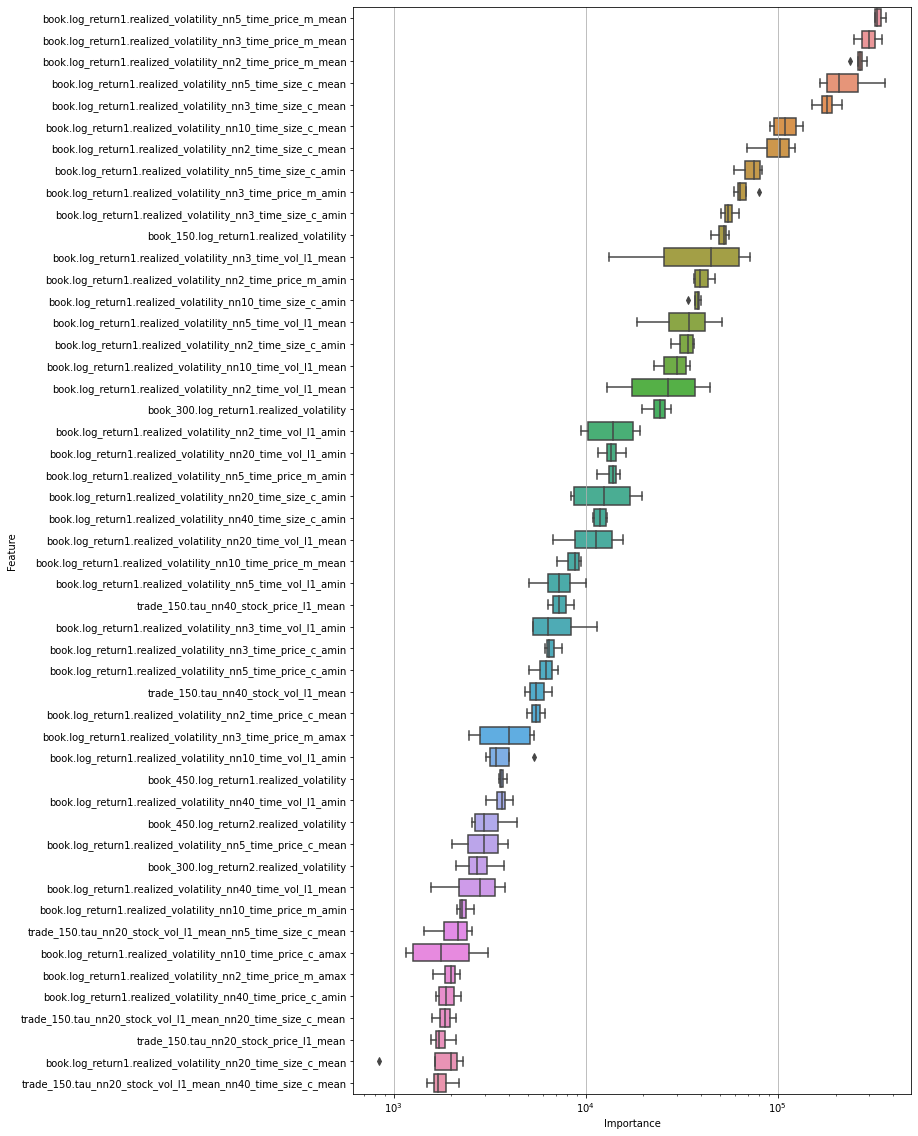

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.251592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.871003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.935411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.589107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.606250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[retraining] 2100.671sec


40333

In [24]:
lr = GBDT_LR
if SHORTCUT_GBDT_IN_1ST_STAGE and IS_1ST_STAGE:
    # to save GPU quota
    lr = 0.3

params = {
    'objective': 'regression',
    'verbose': 0,
    'metric': '',
    'reg_alpha': 5,
    'reg_lambda': 5,
    'min_data_in_leaf': 1000,
    'max_depth': -1,
    'num_leaves': 128,
    'colsample_bytree': 0.3,
    'learning_rate': lr
}

X = get_X(df_train)
y = df_train['target']
X.to_feather('X.f')
df_train[['target']].to_feather('y.f')

gc.collect()

print(X.shape)

if PREDICT_GBDT:
    ds = lgb.Dataset(X, y, weight=1/np.power(y, 2))

    with timer('lgb.cv'):
        ret = lgb.cv(params, ds, num_boost_round=8000, folds=folds, #cv,
                     feval=feval_RMSPE, stratified=False, 
                     return_cvbooster=True, verbose_eval=20,
                     early_stopping_rounds=int(40*0.1/lr))

        print(f"# overall RMSPE: {ret['RMSPE-mean'][-1]}")

    best_iteration = len(ret['RMSPE-mean'])
    for i in range(len(folds)):
        y_pred = ret['cvbooster'].boosters[i].predict(X.iloc[folds[i][1]], num_iteration=best_iteration)
        y_true = y.iloc[folds[i][1]]
        print(f"# fold{i} RMSPE: {rmspe(y_true, y_pred)}")
        
        if i == len(folds) - 1:
            np.save('pred_gbdt.npy', y_pred)

    plot_importance(ret['cvbooster'], figsize=(10, 20))

    boosters = []
    with timer('retraining'):
        for i in range(GBDT_NUM_MODELS):
            params['seed'] = i
            boosters.append(lgb.train(params, ds, num_boost_round=int(1.1*best_iteration)))

    booster = EnsembleModel(boosters)
    del ret
    del ds

gc.collect()

## NN Training

In [25]:
import gc
import os
import random
from typing import List, Tuple, Optional, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


null_check_cols = [
    'book.log_return1.realized_volatility',
    'book_150.log_return1.realized_volatility',
    'book_300.log_return1.realized_volatility',
    'book_450.log_return1.realized_volatility',
    'trade.log_return.realized_volatility',
    'trade_150.log_return.realized_volatility',
    'trade_300.log_return.realized_volatility',
    'trade_450.log_return.realized_volatility'
]


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def rmspe_metric(y_true, y_pred):
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return rmspe


def rmspe_loss(y_true, y_pred):
    rmspe = torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))
    return rmspe


class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))

def RMSPELoss_Tabnet(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()


class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class TabularDataset(Dataset):
    def __init__(self, x_num: np.ndarray, x_cat: np.ndarray, y: Optional[np.ndarray]):
        super().__init__()
        self.x_num = x_num
        self.x_cat = x_cat
        self.y = y

    def __len__(self):
        return len(self.x_num)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx])
        else:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx]), self.y[idx]


class MLP(nn.Module):
    def __init__(self,
                 src_num_dim: int,
                 n_categories: List[int],
                 dropout: float = 0.0,
                 hidden: int = 50,
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 bn: bool = False):
        super().__init__()

        self.embs = nn.ModuleList([
            nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

        if bn:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )
        else:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x_all = torch.cat([x_num, x_cat_emb], 1)
        x = self.sequence(x_all)
        return torch.squeeze(x)


class CNN(nn.Module):
    def __init__(self,
                 num_features: int,
                 hidden_size: int,
                 n_categories: List[int],
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 channel_1: int = 256,
                 channel_2: int = 512,
                 channel_3: int = 512,
                 dropout_top: float = 0.1,
                 dropout_mid: float = 0.3,
                 dropout_bottom: float = 0.2,
                 weight_norm: bool = True,
                 two_stage: bool = True,
                 celu: bool = True,
                 kernel1: int = 5,
                 leaky_relu: bool = False):
        super().__init__()

        num_targets = 1

        cha_1_reshape = int(hidden_size / channel_1)
        cha_po_1 = int(hidden_size / channel_1 / 2)
        cha_po_2 = int(hidden_size / channel_1 / 2 / 2) * channel_3

        self.cat_dim = emb_dim * len(n_categories)
        self.cha_1 = channel_1
        self.cha_2 = channel_2
        self.cha_3 = channel_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2
        self.two_stage = two_stage

        self.expand = nn.Sequential(
            nn.BatchNorm1d(num_features + self.cat_dim),
            nn.Dropout(dropout_top),
            nn.utils.weight_norm(nn.Linear(num_features + self.cat_dim, hidden_size), dim=None),
            nn.CELU(0.06) if celu else nn.ReLU()
        )

        def _norm(layer, dim=None):
            return nn.utils.weight_norm(layer, dim=dim) if weight_norm else layer

        self.conv1 = nn.Sequential(
            nn.BatchNorm1d(channel_1),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_1, channel_2, kernel_size=kernel1, stride=1, 
                            padding=kernel1 // 2, bias=False)),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=cha_po_1),
            nn.BatchNorm1d(channel_2),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
            nn.ReLU()
        )

        if self.two_stage:
            self.conv2 = nn.Sequential(
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_mid),
                _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
                nn.ReLU(),
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Conv1d(channel_2, channel_3, kernel_size=5, stride=1, padding=2, bias=True)),
                nn.ReLU()
            )

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        if leaky_relu:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0),
                nn.LeakyReLU()
            )
        else:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0)
            )

        self.embs = nn.ModuleList([nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x = torch.cat([x_num, x_cat_emb], 1)

        x = self.expand(x)

        x = x.reshape(x.shape[0], self.cha_1, self.cha_1_reshape)

        x = self.conv1(x)

        if self.two_stage:
            x = self.conv2(x) * x

        x = self.max_po_c2(x)
        x = self.flt(x)
        x = self.dense(x)

        return torch.squeeze(x)


def preprocess_nn(
        X: pd.DataFrame,
        scaler: Optional[StandardScaler] = None,
        scaler_type: str = 'standard',
        n_pca: int = -1,
        na_cols: bool = True):
    if na_cols:
        #for c in X.columns:
        for c in null_check_cols:
            if c in X.columns:
                X[f"{c}_isnull"] = X[c].isnull().astype(int)

    cat_cols = [c for c in X.columns if c in ['time_id', 'stock_id']]
    num_cols = [c for c in X.columns if c not in cat_cols]

    X_num = X[num_cols].values.astype(np.float32)
    X_cat = np.nan_to_num(X[cat_cols].values.astype(np.int32))

    def _pca(X_num_):
        if n_pca > 0:
            pca = PCA(n_components=n_pca, random_state=0)
            return pca.fit_transform(X_num)
        return X_num

    if scaler is None:
        scaler = StandardScaler()
        X_num = scaler.fit_transform(X_num)
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols, scaler
    else:
        X_num = scaler.transform(X_num) #TODO: infでも大丈夫？
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols


def train_epoch(data_loader: DataLoader,
                model: nn.Module,
                optimizer,
                scheduler,
                device,
                clip_grad: float = 1.5):
    model.train()
    losses = AverageMeter()
    step = 0

    for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Training'):
        batch_size = x_num.size(0)
        x_num = x_num.to(device, dtype=torch.float)
        x_cat = x_cat.to(device)
        y = y.to(device, dtype=torch.float)

        loss = rmspe_loss(y, model(x_num, x_cat))
        losses.update(loss.detach().cpu().numpy(), batch_size)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        step += 1

    return losses.avg


def evaluate(data_loader: DataLoader, model, device):
    model.eval()

    losses = AverageMeter()

    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            batch_size = x_num.size(0)
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)
            y = y.to(device, dtype=torch.float)

            with torch.no_grad():
                output = model(x_num, x_cat)

            loss = rmspe_loss(y, output)
            # record loss
            losses.update(loss.detach().cpu().numpy(), batch_size)

            targets = y.detach().cpu().numpy()
            output = output.detach().cpu().numpy()

            final_targets.append(targets)
            final_outputs.append(output)

    final_targets = np.concatenate(final_targets)
    final_outputs = np.concatenate(final_outputs)

    try:
        metric = rmspe_metric(final_targets, final_outputs)
    except:
        metric = None

    return final_outputs, final_targets, losses.avg, metric


def predict_nn(X: pd.DataFrame,
               model: Union[List[MLP], MLP],
               scaler: StandardScaler,
               device,
               ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    for m in model:
        m.eval()
    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    valid_dataset = TabularDataset(X_num, X_cat, None)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=512,
                                               shuffle=False,
                                               num_workers=4)

    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat in tqdm(valid_loader, position=0, leave=True, desc='Evaluating'):
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)

            outputs = []
            with torch.no_grad():
                for m in model:
                    output = m(x_num, x_cat)
                    outputs.append(output.detach().cpu().numpy())

            if ensemble_method == 'median':
                pred = np.nanmedian(np.array(outputs), axis=0)
            else:
                pred = np.array(outputs).mean(axis=0)
            final_outputs.append(pred)

    final_outputs = np.concatenate(final_outputs)
    return final_outputs


def predict_tabnet(X: pd.DataFrame,
                   model: Union[List[TabNetRegressor], TabNetRegressor],
                   scaler: StandardScaler,
                   ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    X_processed = np.concatenate([X_cat, X_num], axis=1)

    predicted = []
    for m in model:
        predicted.append(m.predict(X_processed))

    if ensemble_method == 'median':
        pred = np.nanmedian(np.array(predicted), axis=0)
    else:
        pred = np.array(predicted).mean(axis=0)

    return pred


def train_tabnet(X: pd.DataFrame,
                 y: pd.DataFrame,
                 folds: List[Tuple],
                 batch_size: int = 1024,
                 lr: float = 1e-3,
                 model_path: str = 'fold_{}.pth',
                 scaler_type: str = 'standard',
                 output_dir: str = 'artifacts',
                 epochs: int = 250,
                 seed: int = 42,
                 n_pca: int = -1,
                 na_cols: bool = True,
                 patience: int = 10,
                 factor: float = 0.5,
                 gamma: float = 2.0,
                 lambda_sparse: float = 8.0,
                 n_steps: int = 2,
                 scheduler_type: str = 'cosine',
                 n_a: int = 16):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type,
                                                   n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []

    for cv_idx, (train_idx, valid_idx) in enumerate(folds):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]
        y_tr = y_tr.reshape(-1,1)
        y_va = y_va.reshape(-1,1)
        X_tr = np.concatenate([X_tr_cat, X_tr], axis=1)
        X_va = np.concatenate([X_va_cat, X_va], axis=1)

        cat_idxs = [0]
        cat_dims = [128]

        if scheduler_type == 'cosine':
            scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4,
                                    last_epoch=-1, verbose=False)
            scheduler_fn = CosineAnnealingWarmRestarts
        else:
            scheduler_params = {'mode': 'min', 'min_lr': 1e-7, 'patience': patience,
                                'factor': factor, 'verbose': True}
            scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau

        model = TabNetRegressor(
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=1,
            n_d=n_a,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            n_independent=2,
            n_shared=2,
            lambda_sparse=lambda_sparse,
            optimizer_fn=torch.optim.Adam,
            optimizer_params={'lr': lr},
            mask_type="entmax",
            scheduler_fn=scheduler_fn,
            scheduler_params=scheduler_params,
            seed=seed,
            verbose=10
            #device_name=device,
            #clip_value=1.5
        )

        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], max_epochs=epochs,
                  patience=50, batch_size=1024*20,
                  virtual_batch_size=batch_size, num_workers=4, 
                  drop_last=False, eval_metric=[RMSPE], loss_fn=RMSPELoss_Tabnet)

        path = os.path.join(output_dir, model_path.format(cv_idx))
        model.save_model(path)

        predicted = model.predict(X_va)

        rmspe = rmspe_metric(y_va, predicted)
        best_losses.append(rmspe)
        best_predictions.append(predicted)

    return best_losses, best_predictions, scaler, model


def train_nn(X: pd.DataFrame,
             y: pd.DataFrame,
             folds: List[Tuple],
             device,
             emb_dim: int = 25,
             batch_size: int = 1024,
             model_type: str = 'mlp',
             mlp_dropout: float = 0.0,
             mlp_hidden: int = 64,
             mlp_bn: bool = False,
             cnn_hidden: int = 64,
             cnn_channel1: int = 32,
             cnn_channel2: int = 32,
             cnn_channel3: int = 32,
             cnn_kernel1: int = 5,
             cnn_celu: bool = False,
             cnn_weight_norm: bool = False,
             dropout_emb: bool = 0.0,
             lr: float = 1e-3,
             weight_decay: float = 0.0,
             model_path: str = 'fold_{}.pth',
             scaler_type: str = 'standard',
             output_dir: str = 'artifacts',
             scheduler_type: str = 'onecycle',
             optimizer_type: str = 'adam',
             max_lr: float = 0.01,
             epochs: int = 30,
             seed: int = 42,
             n_pca: int = -1,
             batch_double_freq: int = 50,
             cnn_dropout: float = 0.1,
             na_cols: bool = True,
             cnn_leaky_relu: bool = False,
             patience: int = 8,
             factor: float = 0.5):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), 
                                                   scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []

    for cv_idx, (train_idx, valid_idx) in enumerate(folds):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]

        cur_batch = batch_size
        best_loss = 1e10
        best_prediction = None

        print(f"fold {cv_idx} train: {X_tr.shape}, valid: {X_va.shape}")

        train_dataset = TabularDataset(X_tr, X_tr_cat, y_tr)
        valid_dataset = TabularDataset(X_va, X_va_cat, y_va)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cur_batch, shuffle=True,
                                                   num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=cur_batch, shuffle=False,
                                                   num_workers=4)

        if model_type == 'mlp':
            model = MLP(X_tr.shape[1],
                        n_categories=[128],
                        dropout=mlp_dropout, hidden=mlp_hidden, emb_dim=emb_dim,
                        dropout_cat=dropout_emb, bn=mlp_bn)
        elif model_type == 'cnn':
            model = CNN(X_tr.shape[1],
                        hidden_size=cnn_hidden,
                        n_categories=[128],
                        emb_dim=emb_dim,
                        dropout_cat=dropout_emb,
                        channel_1=cnn_channel1,
                        channel_2=cnn_channel2,
                        channel_3=cnn_channel3,
                        two_stage=False,
                        kernel1=cnn_kernel1,
                        celu=cnn_celu,
                        dropout_top=cnn_dropout,
                        dropout_mid=cnn_dropout,
                        dropout_bottom=cnn_dropout,
                        weight_norm=cnn_weight_norm,
                        leaky_relu=cnn_leaky_relu)
        else:
            raise NotImplementedError()
        model = model.to(device)

        if optimizer_type == 'adamw':
            opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'adam':
            opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            raise NotImplementedError()

        scheduler = epoch_scheduler = None
        if scheduler_type == 'onecycle':
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=opt, pct_start=0.1, div_factor=1e3,
                                                            max_lr=max_lr, epochs=epochs,
                                                            steps_per_epoch=len(train_loader))
        elif scheduler_type == 'reduce':
            epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt,
                                                                         mode='min',
                                                                         min_lr=1e-7,
                                                                         patience=patience,
                                                                         verbose=True,
                                                                         factor=factor)

        for epoch in range(epochs):
            if epoch > 0 and epoch % batch_double_freq == 0:
                cur_batch = cur_batch * 2
                print(f'batch: {cur_batch}')
                train_loader = torch.utils.data.DataLoader(train_dataset,
                                                           batch_size=cur_batch,
                                                           shuffle=True,
                                                           num_workers=4)
            train_loss = train_epoch(train_loader, model, opt, scheduler, device)
            predictions, valid_targets, valid_loss, rmspe = evaluate(valid_loader, model, device=device)
            print(f"epoch {epoch}, train loss: {train_loss:.3f}, valid rmspe: {rmspe:.3f}")

            if epoch_scheduler is not None:
                epoch_scheduler.step(rmspe)

            if rmspe < best_loss:
                print(f'new best:{rmspe}')
                best_loss = rmspe
                best_prediction = predictions
                torch.save(model, os.path.join(output_dir, model_path.format(cv_idx)))

        best_predictions.append(best_prediction)
        best_losses.append(best_loss)
        del model, train_dataset, valid_dataset, train_loader, valid_loader,
        X_tr, X_va, X_tr_cat, X_va_cat, y_tr, y_va, opt
        if scheduler is not None:
            del scheduler
        gc.collect()

    return best_losses, best_predictions, scaler


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

del df, df_train
gc.collect()

def get_top_n_models(models, scores, top_n):
    if len(models) <= top_n:
        print('number of models are less than top_n. all models will be used')
        return models
    sorted_ = [(y, x) for y, x in sorted(zip(scores, models), key=lambda pair: pair[0])]
    print(f'scores(sorted): {[y for y, _ in sorted_]}')
    return [x for _, x in sorted_][:top_n]


if PREDICT_MLP:
    model_paths = []
    scores = []
    
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 3
        valid_th = 100
    else:
        epochs = 30
        valid_th = NN_VALID_TH
    
    for i in range(NN_NUM_MODELS):
        # MLP
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               [folds[-1]], 
                                               device=device, 
                                               batch_size=512,
                                               mlp_bn=True,
                                               mlp_hidden=256,
                                               mlp_dropout=0.0,
                                               emb_dim=30,
                                               epochs=epochs,
                                               lr=0.002,
                                               max_lr=0.0055,
                                               weight_decay=1e-7,
                                               model_path='mlp_fold_{}' + f"_seed{i}.pth",
                                               seed=i)
        if nn_losses[0] < NN_VALID_TH:
            print(f'model of seed {i} added.')
            scores.append(nn_losses[0])
            model_paths.append(f'artifacts/mlp_fold_0_seed{i}.pth')
            np.save(f'pred_mlp_seed{i}.npy', nn_preds[0])

    model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
    mlp_model = [torch.load(path, device) for path in model_paths]
    print(f'total {len(mlp_model)} models will be used.')
if PREDICT_CNN:
    model_paths = []
    scores = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 3
        valid_th = 100
    else:
        epochs = 50
        valid_th = NN_VALID_TH

    for i in range(NN_NUM_MODELS):
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               [folds[-1]], 
                                               device=device, 
                                               cnn_hidden=8*128,
                                               batch_size=1280,
                                               model_type='cnn',
                                               emb_dim=30,
                                               epochs=epochs, #epochs,
                                               cnn_channel1=128,
                                               cnn_channel2=3*128,
                                               cnn_channel3=3*128,
                                               lr=0.00038, #0.0011,
                                               max_lr=0.0013,
                                               weight_decay=6.5e-6,
                                               optimizer_type='adam',
                                               scheduler_type='reduce',
                                               model_path='cnn_fold_{}' + f"_seed{i}.pth",
                                               seed=i,
                                               cnn_dropout=0.0,
                                               cnn_weight_norm=True,
                                               cnn_leaky_relu=False,
                                               patience=8,
                                               factor=0.3)
        if nn_losses[0] < valid_th:
            model_paths.append(f'artifacts/cnn_fold_0_seed{i}.pth')
            scores.append(nn_losses[0])
            np.save(f'pred_cnn_seed{i}.npy', nn_preds[0])
            
    model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
    cnn_model = [torch.load(path, device) for path in model_paths]
    print(f'total {len(cnn_model)} models will be used.')
    
if PREDICT_TABNET:
    tab_model = []
    scores = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 10
        valid_th = 1000
    else:
        print('train full')
        epochs = 250
        valid_th = NN_VALID_TH

    for i in range(TABNET_NUM_MODELS):
        nn_losses, nn_preds, scaler, model = train_tabnet(X, y,  
                                                          [folds[-1]], 
                                                          batch_size=1280,
                                                          epochs=epochs, #epochs,
                                                          lr=0.04,
                                                          patience=50,
                                                          factor=0.5,
                                                          gamma=1.6,
                                                          lambda_sparse=3.55e-6,
                                                          seed=i,
                                                          n_a=36)
        if nn_losses[0] < valid_th:
            tab_model.append(model)
            scores.append(nn_losses[0])
            np.save(f'pred_tab_seed{i}.npy', nn_preds[0])
            model.save_model(f'artifacts/tabnet_fold_0_seed{i}')
            
    tab_model = get_top_n_models(tab_model, scores, TAB_MODEL_TOP_N)
    print(f'total {len(tab_model)} models will be used.')

cuda
fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 21.544, valid rmspe: 3.555
new best:3.5548722743988037


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 5.478, valid rmspe: 4.388


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 5.763, valid rmspe: 3.002
new best:3.0017120838165283


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 2.365, valid rmspe: 1.426
new best:1.4262170791625977


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 1.146, valid rmspe: 0.321
new best:0.32077842950820923


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.549, valid rmspe: 0.328


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.552, valid rmspe: 0.643


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.577, valid rmspe: 0.230
new best:0.23008973896503448


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.493, valid rmspe: 0.571


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.535, valid rmspe: 0.780


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.437, valid rmspe: 0.337


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.401, valid rmspe: 0.350


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.437, valid rmspe: 0.351


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.404, valid rmspe: 0.198
new best:0.19765082001686096


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.346, valid rmspe: 0.277


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.324, valid rmspe: 0.270


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.291, valid rmspe: 0.210


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.269, valid rmspe: 0.186
new best:0.1859540045261383


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.254, valid rmspe: 0.201


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.263, valid rmspe: 0.302


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.253, valid rmspe: 0.254


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.254, valid rmspe: 0.217


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.229, valid rmspe: 0.197


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.219, valid rmspe: 0.183
new best:0.1834007203578949


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.214, valid rmspe: 0.215


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.208, valid rmspe: 0.193


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.208, valid rmspe: 0.198


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.201, valid rmspe: 0.184


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.198, valid rmspe: 0.184


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 55.76it/s]


epoch 29, train loss: 0.197, valid rmspe: 0.183
new best:0.18260832130908966
model of seed 0 added.


Training:   0%|          | 0/754 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 26.458, valid rmspe: 5.718
new best:5.71785831451416


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 7.088, valid rmspe: 2.920
new best:2.9196858406066895


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 4.277, valid rmspe: 1.276
new best:1.2764371633529663


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 1.603, valid rmspe: 0.818
new best:0.8175786137580872


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 0.745, valid rmspe: 1.012


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.758, valid rmspe: 0.421
new best:0.4210692346096039


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.551, valid rmspe: 0.854


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.634, valid rmspe: 0.309
new best:0.30856844782829285


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.549, valid rmspe: 0.411


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.307, valid rmspe: 0.202
new best:0.2017420083284378


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.454, valid rmspe: 0.348


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.376, valid rmspe: 0.229


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.399, valid rmspe: 0.206


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.321, valid rmspe: 0.463


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.312, valid rmspe: 0.222


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.303, valid rmspe: 0.219


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.273, valid rmspe: 0.246


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.289, valid rmspe: 0.219


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.281, valid rmspe: 0.201
new best:0.2005404531955719


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.248, valid rmspe: 0.194
new best:0.19405578076839447


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.249, valid rmspe: 0.191
new best:0.1905241459608078


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.233, valid rmspe: 0.185
new best:0.18480995297431946


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.224, valid rmspe: 0.205


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.222, valid rmspe: 0.234


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.209, valid rmspe: 0.186


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.213, valid rmspe: 0.205


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.203, valid rmspe: 0.190


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.201, valid rmspe: 0.188


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.198, valid rmspe: 0.182
new best:0.18223118782043457


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.08it/s]


epoch 29, train loss: 0.196, valid rmspe: 0.183
model of seed 1 added.


Training:   0%|          | 0/754 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 22.422, valid rmspe: 6.694
new best:6.693961143493652


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 6.397, valid rmspe: 5.946
new best:5.945800304412842


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 5.125, valid rmspe: 2.184
new best:2.183828353881836


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 2.068, valid rmspe: 0.664
new best:0.6643406748771667


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 0.774, valid rmspe: 0.633
new best:0.6334158778190613


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.725, valid rmspe: 0.224
new best:0.22352604568004608


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.640, valid rmspe: 0.655


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.573, valid rmspe: 0.744


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.620, valid rmspe: 0.409


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.538, valid rmspe: 0.549


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.551, valid rmspe: 0.293


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.531, valid rmspe: 0.444


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.434, valid rmspe: 0.492


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.443, valid rmspe: 0.193
new best:0.1926783323287964


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.389, valid rmspe: 0.406


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.372, valid rmspe: 0.315


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.371, valid rmspe: 0.313


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.331, valid rmspe: 0.291


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.329, valid rmspe: 0.192
new best:0.19156382977962494


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.302, valid rmspe: 0.240


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.269, valid rmspe: 0.244


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.258, valid rmspe: 0.315


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.246, valid rmspe: 0.189
new best:0.18922364711761475


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.227, valid rmspe: 0.223


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.226, valid rmspe: 0.195


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.216, valid rmspe: 0.183
new best:0.18329356610774994


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.207, valid rmspe: 0.187


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.204, valid rmspe: 0.187


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.201, valid rmspe: 0.183
new best:0.18294598162174225


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.37it/s]


epoch 29, train loss: 0.200, valid rmspe: 0.183
model of seed 2 added.


Training:   0%|          | 0/754 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 26.689, valid rmspe: 5.324
new best:5.323751926422119


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 6.216, valid rmspe: 2.713
new best:2.712800979614258


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 4.738, valid rmspe: 3.637


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 1.989, valid rmspe: 0.832
new best:0.8324441909790039


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 0.843, valid rmspe: 0.584
new best:0.5838446021080017


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.701, valid rmspe: 0.752


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.609, valid rmspe: 0.235
new best:0.2346353828907013


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.497, valid rmspe: 0.304


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.414, valid rmspe: 0.255


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.463, valid rmspe: 0.325


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.514, valid rmspe: 0.561


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.471, valid rmspe: 0.267


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.438, valid rmspe: 0.478


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.434, valid rmspe: 0.598


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.336, valid rmspe: 0.260


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.307, valid rmspe: 0.516


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.312, valid rmspe: 0.237


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.310, valid rmspe: 0.188
new best:0.18839620053768158


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.289, valid rmspe: 0.242


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.254, valid rmspe: 0.260


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.253, valid rmspe: 0.194


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.244, valid rmspe: 0.243


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.222, valid rmspe: 0.184
new best:0.18372046947479248


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.225, valid rmspe: 0.230


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.216, valid rmspe: 0.186


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.208, valid rmspe: 0.194


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.201, valid rmspe: 0.183
new best:0.18305735290050507


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.198, valid rmspe: 0.182
new best:0.18172310292720795


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.197, valid rmspe: 0.182


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.30it/s]


epoch 29, train loss: 0.196, valid rmspe: 0.182
model of seed 3 added.


Training:   0%|          | 0/754 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 24.463, valid rmspe: 12.338
new best:12.337745666503906


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 6.505, valid rmspe: 3.392
new best:3.3917229175567627


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 5.363, valid rmspe: 4.522


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 1.778, valid rmspe: 0.763
new best:0.7631120681762695


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 0.676, valid rmspe: 0.449
new best:0.4491562247276306


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.747, valid rmspe: 0.457


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.668, valid rmspe: 0.691


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.664, valid rmspe: 0.718


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.682, valid rmspe: 0.732


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.611, valid rmspe: 0.474


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.645, valid rmspe: 0.440
new best:0.4400481581687927


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.504, valid rmspe: 0.234
new best:0.23421593010425568


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.533, valid rmspe: 0.231
new best:0.23072731494903564


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.490, valid rmspe: 0.537


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.467, valid rmspe: 0.567


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.382, valid rmspe: 0.555


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.399, valid rmspe: 0.190
new best:0.18965180218219757


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.342, valid rmspe: 0.203


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.327, valid rmspe: 0.197


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.289, valid rmspe: 0.214


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.268, valid rmspe: 0.296


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.259, valid rmspe: 0.216


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.238, valid rmspe: 0.188
new best:0.18842355906963348


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.236, valid rmspe: 0.186
new best:0.18588276207447052


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.225, valid rmspe: 0.191


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.214, valid rmspe: 0.184
new best:0.1839165836572647


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.210, valid rmspe: 0.184
new best:0.18366336822509766


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.203, valid rmspe: 0.189


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.201, valid rmspe: 0.184
new best:0.18358463048934937


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.59it/s]


epoch 29, train loss: 0.199, valid rmspe: 0.184
model of seed 4 added.


Training:   0%|          | 0/754 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 27.857, valid rmspe: 2.365
new best:2.365215539932251


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 5.941, valid rmspe: 7.107


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 5.457, valid rmspe: 1.188
new best:1.1875132322311401


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 2.599, valid rmspe: 2.248


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 1.269, valid rmspe: 0.418
new best:0.41831788420677185


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.649, valid rmspe: 0.391
new best:0.39083465933799744


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.573, valid rmspe: 0.210
new best:0.20969435572624207


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.534, valid rmspe: 0.384


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.503, valid rmspe: 0.767


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.557, valid rmspe: 0.233


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.314, valid rmspe: 0.261


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.459, valid rmspe: 0.249


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.366, valid rmspe: 0.282


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.415, valid rmspe: 0.210
new best:0.20959249138832092


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.293, valid rmspe: 0.224


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.330, valid rmspe: 0.188
new best:0.18767157196998596


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.294, valid rmspe: 0.223


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.285, valid rmspe: 0.199


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.288, valid rmspe: 0.199


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.267, valid rmspe: 0.229


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.249, valid rmspe: 0.202


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.240, valid rmspe: 0.185
new best:0.1852767914533615


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.229, valid rmspe: 0.194


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.221, valid rmspe: 0.222


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.214, valid rmspe: 0.182
new best:0.18238721787929535


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.209, valid rmspe: 0.183


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.202, valid rmspe: 0.182
new best:0.18226666748523712


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.200, valid rmspe: 0.182
new best:0.18204563856124878


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.197, valid rmspe: 0.184


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.62it/s]


epoch 29, train loss: 0.196, valid rmspe: 0.184
model of seed 5 added.


Training:   0%|          | 0/754 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 23.347, valid rmspe: 3.038
new best:3.038130760192871


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 5.840, valid rmspe: 6.187


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 5.762, valid rmspe: 0.776
new best:0.7763923406600952


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 1.539, valid rmspe: 0.379
new best:0.37855467200279236


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 0.762, valid rmspe: 0.742


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.778, valid rmspe: 1.107


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.745, valid rmspe: 1.406


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.699, valid rmspe: 0.515


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.535, valid rmspe: 0.760


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.606, valid rmspe: 0.399


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.552, valid rmspe: 0.345
new best:0.3448259234428406


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.504, valid rmspe: 0.336
new best:0.33602476119995117


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.448, valid rmspe: 0.316
new best:0.3161602020263672


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.424, valid rmspe: 0.591


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.418, valid rmspe: 0.371


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.405, valid rmspe: 0.383


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.417, valid rmspe: 0.197
new best:0.1965900957584381


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.372, valid rmspe: 0.470


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.327, valid rmspe: 0.241


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.297, valid rmspe: 0.229


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.275, valid rmspe: 0.195
new best:0.1952923834323883


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.255, valid rmspe: 0.208


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.245, valid rmspe: 0.187
new best:0.18682996928691864


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.235, valid rmspe: 0.213


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.228, valid rmspe: 0.212


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.216, valid rmspe: 0.188


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.212, valid rmspe: 0.184
new best:0.18444830179214478


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.206, valid rmspe: 0.184
new best:0.18395297229290009


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.201, valid rmspe: 0.183
new best:0.18342769145965576


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 60.38it/s]


epoch 29, train loss: 0.200, valid rmspe: 0.183
new best:0.18322348594665527
model of seed 6 added.


Training:   0%|          | 0/754 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 23.879, valid rmspe: 5.903
new best:5.902618885040283


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 5.686, valid rmspe: 6.517


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 5.878, valid rmspe: 1.631
new best:1.6306726932525635


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 1.985, valid rmspe: 0.654
new best:0.6541109681129456


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 0.898, valid rmspe: 0.589
new best:0.589432954788208


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.712, valid rmspe: 0.586
new best:0.5857896208763123


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.662, valid rmspe: 0.637


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.636, valid rmspe: 0.681


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.573, valid rmspe: 1.549


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.567, valid rmspe: 0.227
new best:0.22670604288578033


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.492, valid rmspe: 0.215
new best:0.21504457294940948


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.495, valid rmspe: 0.358


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.492, valid rmspe: 0.302


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.411, valid rmspe: 0.211
new best:0.21112766861915588


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.371, valid rmspe: 0.404


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.391, valid rmspe: 0.717


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.348, valid rmspe: 0.221


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.332, valid rmspe: 0.187
new best:0.1874726414680481


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.311, valid rmspe: 0.240


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.302, valid rmspe: 0.189


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.272, valid rmspe: 0.236


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.249, valid rmspe: 0.211


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.245, valid rmspe: 0.226


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.226, valid rmspe: 0.185
new best:0.18546843528747559


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.218, valid rmspe: 0.262


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.222, valid rmspe: 0.183
new best:0.18326179683208466


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.208, valid rmspe: 0.210


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.201, valid rmspe: 0.187


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.200, valid rmspe: 0.182
new best:0.18239477276802063


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 50.50it/s]


epoch 29, train loss: 0.198, valid rmspe: 0.184
model of seed 7 added.


Training:   0%|          | 0/754 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 24.876, valid rmspe: 4.769
new best:4.769461154937744


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 6.570, valid rmspe: 2.795
new best:2.7953550815582275


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 5.955, valid rmspe: 1.775
new best:1.7748996019363403


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 2.184, valid rmspe: 1.699
new best:1.6987789869308472


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 0.960, valid rmspe: 0.667
new best:0.6671402454376221


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.616, valid rmspe: 0.232
new best:0.23224562406539917


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.479, valid rmspe: 0.244


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.550, valid rmspe: 0.411


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.677, valid rmspe: 0.410


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.551, valid rmspe: 0.548


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.555, valid rmspe: 0.536


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.549, valid rmspe: 0.690


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.461, valid rmspe: 0.928


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.431, valid rmspe: 0.221
new best:0.22054427862167358


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.441, valid rmspe: 0.206
new best:0.20569781959056854


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.396, valid rmspe: 0.519


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.371, valid rmspe: 0.636


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.335, valid rmspe: 0.211


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.304, valid rmspe: 0.199
new best:0.19889619946479797


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.279, valid rmspe: 0.277


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.270, valid rmspe: 0.259


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.259, valid rmspe: 0.185
new best:0.18466268479824066


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.247, valid rmspe: 0.195


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.229, valid rmspe: 0.203


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.225, valid rmspe: 0.198


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.220, valid rmspe: 0.184
new best:0.18351253867149353


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.211, valid rmspe: 0.184


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.203, valid rmspe: 0.183
new best:0.18297065794467926


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.201, valid rmspe: 0.183


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 61.14it/s]


epoch 29, train loss: 0.200, valid rmspe: 0.183
model of seed 8 added.


Training:   0%|          | 0/754 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 0, train loss: 25.829, valid rmspe: 11.458
new best:11.457991600036621


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 1, train loss: 6.858, valid rmspe: 5.509
new best:5.509047031402588


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 2, train loss: 4.784, valid rmspe: 1.682
new best:1.6817419528961182


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 3, train loss: 1.827, valid rmspe: 0.294
new best:0.2939322590827942


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 4, train loss: 0.719, valid rmspe: 0.577


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 5, train loss: 0.570, valid rmspe: 0.474


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 6, train loss: 0.525, valid rmspe: 1.073


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 7, train loss: 0.510, valid rmspe: 0.199
new best:0.1992027759552002


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 8, train loss: 0.492, valid rmspe: 0.287


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 9, train loss: 0.382, valid rmspe: 0.210


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 10, train loss: 0.383, valid rmspe: 0.413


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 11, train loss: 0.340, valid rmspe: 0.270


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 12, train loss: 0.314, valid rmspe: 0.212


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 13, train loss: 0.330, valid rmspe: 0.320


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 14, train loss: 0.365, valid rmspe: 0.373


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 15, train loss: 0.339, valid rmspe: 0.239


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 16, train loss: 0.304, valid rmspe: 0.189
new best:0.18938685953617096


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 17, train loss: 0.279, valid rmspe: 0.184
new best:0.18415793776512146


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 18, train loss: 0.275, valid rmspe: 0.190


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 19, train loss: 0.258, valid rmspe: 0.187


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 20, train loss: 0.248, valid rmspe: 0.185


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 21, train loss: 0.236, valid rmspe: 0.187


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 22, train loss: 0.224, valid rmspe: 0.188


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 23, train loss: 0.223, valid rmspe: 0.189


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 24, train loss: 0.215, valid rmspe: 0.183
new best:0.18332572281360626


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 25, train loss: 0.207, valid rmspe: 0.189


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 26, train loss: 0.204, valid rmspe: 0.185


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 27, train loss: 0.201, valid rmspe: 0.183
new best:0.18257185816764832


Training:   0%|          | 0/754 [00:00<?, ?it/s]

epoch 28, train loss: 0.198, valid rmspe: 0.182
new best:0.1824578046798706


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 50.50it/s]


epoch 29, train loss: 0.197, valid rmspe: 0.183
model of seed 9 added.
scores(sorted): [0.1817231, 0.18204564, 0.18223119, 0.18239477, 0.1824578, 0.18260832, 0.18294598, 0.18297066, 0.18322349, 0.18358463]
total 3 models will be used.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 36.847, valid rmspe: 13.479
new best:13.479052543640137


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 6.999, valid rmspe: 11.602
new best:11.602226257324219


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 6.338, valid rmspe: 3.183
new best:3.1833648681640625


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 4.711, valid rmspe: 5.562


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 4.004, valid rmspe: 3.696


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 2.540, valid rmspe: 5.343


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 2.675, valid rmspe: 1.612
new best:1.6116986274719238


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 1.750, valid rmspe: 0.838
new best:0.8377463817596436


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 2.455, valid rmspe: 0.642
new best:0.6421473622322083


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 1.853, valid rmspe: 1.397


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 1.457, valid rmspe: 1.241


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 1.112, valid rmspe: 1.306


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 0.893, valid rmspe: 0.860


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 1.165, valid rmspe: 8.129


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.836, valid rmspe: 1.082


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 0.799, valid rmspe: 0.527
new best:0.5268535614013672


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.686, valid rmspe: 0.525
new best:0.5245238542556763


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.619, valid rmspe: 0.419
new best:0.41871848702430725


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.755, valid rmspe: 1.512


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.670, valid rmspe: 0.285
new best:0.2850245237350464


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.515, valid rmspe: 0.580


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.461, valid rmspe: 0.290


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.569, valid rmspe: 0.696


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.532, valid rmspe: 0.288


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.623, valid rmspe: 0.383


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.498, valid rmspe: 0.327


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.636, valid rmspe: 0.392


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.493, valid rmspe: 0.376


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.426, valid rmspe: 0.486
Epoch    29: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.289, valid rmspe: 0.250
new best:0.25037774443626404


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.227, valid rmspe: 0.199
new best:0.19857917726039886


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.271, valid rmspe: 0.251


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.246, valid rmspe: 0.190
new best:0.1901816576719284


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.258, valid rmspe: 0.191


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.239, valid rmspe: 0.186
new best:0.18596062064170837


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.223, valid rmspe: 0.244


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.286, valid rmspe: 0.193


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.243, valid rmspe: 0.194


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.241, valid rmspe: 0.193


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.262, valid rmspe: 0.193


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.250, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.220, valid rmspe: 0.201


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.255, valid rmspe: 0.202


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.250, valid rmspe: 0.212
Epoch    44: reducing learning rate of group 0 to 3.4200e-05.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.199, valid rmspe: 0.183
new best:0.1831517070531845


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.197, valid rmspe: 0.182
new best:0.18218174576759338


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.196, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.197, valid rmspe: 0.186


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.229, valid rmspe: 0.187


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.74it/s]


epoch 49, train loss: 0.197, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 32.680, valid rmspe: 13.425
new best:13.425479888916016


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 9.076, valid rmspe: 5.088
new best:5.088461875915527


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 6.327, valid rmspe: 2.818
new best:2.8181731700897217


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 6.716, valid rmspe: 2.509
new best:2.508608102798462


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 3.884, valid rmspe: 5.407


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 3.258, valid rmspe: 2.717


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 2.524, valid rmspe: 1.320
new best:1.3204846382141113


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 1.849, valid rmspe: 2.537


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 1.214, valid rmspe: 0.536
new best:0.5358614921569824


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 0.458, valid rmspe: 0.342
new best:0.3423343896865845


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 0.240, valid rmspe: 0.186
new best:0.18570788204669952


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 0.216, valid rmspe: 0.196


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 0.224, valid rmspe: 0.193


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 0.210, valid rmspe: 0.184
new best:0.1835884153842926


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.215, valid rmspe: 0.230


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 0.208, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.210, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.207, valid rmspe: 0.235


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.213, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.204, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.209, valid rmspe: 0.198


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.211, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.207, valid rmspe: 0.204
Epoch    23: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.198, valid rmspe: 0.192


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.199, valid rmspe: 0.182
new best:0.18177354335784912


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.196, valid rmspe: 0.181
new best:0.18146094679832458


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.195, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.196, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.195, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.197, valid rmspe: 0.201


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.197, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.196, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.195, valid rmspe: 0.192


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.195, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.195, valid rmspe: 0.182
Epoch    35: reducing learning rate of group 0 to 3.4200e-05.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.190, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.190, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.191, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.190, valid rmspe: 0.180
new best:0.18033888936042786


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.189, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.189, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.189, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.188, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.189, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.189, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.188, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.188, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.188, valid rmspe: 0.183
Epoch    48: reducing learning rate of group 0 to 1.0260e-05.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.186, valid rmspe: 0.182


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 21.17it/s]


epoch 49, train loss: 0.186, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 26.282, valid rmspe: 7.520
new best:7.5200018882751465


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 5.948, valid rmspe: 2.820
new best:2.819704294204712


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 4.182, valid rmspe: 8.928


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 5.051, valid rmspe: 3.035


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 3.475, valid rmspe: 1.584
new best:1.5843538045883179


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 2.889, valid rmspe: 3.414


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 3.170, valid rmspe: 3.476


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 3.001, valid rmspe: 1.881


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 1.891, valid rmspe: 1.118
new best:1.117576003074646


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 1.139, valid rmspe: 1.055
new best:1.0551148653030396


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 1.787, valid rmspe: 1.770


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 1.460, valid rmspe: 0.909
new best:0.9094849824905396


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 1.070, valid rmspe: 1.164


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 0.828, valid rmspe: 0.731
new best:0.7307140231132507


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.766, valid rmspe: 0.334
new best:0.33379241824150085


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 0.596, valid rmspe: 1.100


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.629, valid rmspe: 0.230
new best:0.23013845086097717


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.562, valid rmspe: 0.307


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.601, valid rmspe: 0.432


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.519, valid rmspe: 0.363


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.390, valid rmspe: 0.242


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.368, valid rmspe: 0.388


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.469, valid rmspe: 0.220
new best:0.22024667263031006


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.429, valid rmspe: 0.252


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.379, valid rmspe: 0.344


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.332, valid rmspe: 0.604


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.404, valid rmspe: 0.207
new best:0.20687156915664673


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.297, valid rmspe: 0.193
new best:0.19253328442573547


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.253, valid rmspe: 0.234


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.224, valid rmspe: 0.205


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.213, valid rmspe: 0.188
new best:0.18815135955810547


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.215, valid rmspe: 0.190


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.217, valid rmspe: 0.189


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.205, valid rmspe: 0.189


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.205, valid rmspe: 0.184
new best:0.18394017219543457


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.206, valid rmspe: 0.224


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.201, valid rmspe: 0.182
new best:0.18236659467220306


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.206, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.203, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.203, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.204, valid rmspe: 0.195


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.202, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.205, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.204, valid rmspe: 0.205


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.211, valid rmspe: 0.201


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.218, valid rmspe: 0.204
Epoch    46: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.201, valid rmspe: 0.182
new best:0.1816081404685974


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.199, valid rmspe: 0.182
new best:0.18159614503383636


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.196, valid rmspe: 0.193


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.02it/s]


epoch 49, train loss: 0.196, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 30.133, valid rmspe: 6.609
new best:6.609215259552002


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 5.277, valid rmspe: 4.785
new best:4.785083770751953


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 4.854, valid rmspe: 3.869
new best:3.869030237197876


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 5.164, valid rmspe: 3.987


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 4.382, valid rmspe: 2.476
new best:2.4758026599884033


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 3.466, valid rmspe: 2.426
new best:2.426433563232422


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 2.795, valid rmspe: 0.709
new best:0.7089231610298157


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 2.619, valid rmspe: 3.411


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 1.844, valid rmspe: 1.836


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 1.430, valid rmspe: 0.894


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 1.363, valid rmspe: 2.194


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 1.317, valid rmspe: 0.598
new best:0.5980517864227295


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 1.058, valid rmspe: 0.756


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 0.938, valid rmspe: 0.653


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.670, valid rmspe: 0.473
new best:0.4728221297264099


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 0.570, valid rmspe: 0.265
new best:0.26464933156967163


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.643, valid rmspe: 1.404


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.666, valid rmspe: 1.215


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.556, valid rmspe: 0.407


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.553, valid rmspe: 0.728


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.467, valid rmspe: 0.226
new best:0.22584238648414612


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.473, valid rmspe: 0.716


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.478, valid rmspe: 0.431


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.527, valid rmspe: 0.334


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.399, valid rmspe: 0.559


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.433, valid rmspe: 0.784


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.510, valid rmspe: 0.636


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.336, valid rmspe: 0.691


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.419, valid rmspe: 0.196
new best:0.19555743038654327


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.411, valid rmspe: 0.531


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.325, valid rmspe: 0.192
new best:0.19205337762832642


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.413, valid rmspe: 0.359


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.304, valid rmspe: 0.203


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.311, valid rmspe: 0.234


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.271, valid rmspe: 0.182
new best:0.18230053782463074


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.269, valid rmspe: 0.186


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.259, valid rmspe: 0.238


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.241, valid rmspe: 0.195


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.235, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.227, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.209, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.219, valid rmspe: 0.289


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.212, valid rmspe: 0.196


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.213, valid rmspe: 0.183
Epoch    44: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.198, valid rmspe: 0.192


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.196, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.197, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.197, valid rmspe: 0.182
new best:0.18190747499465942


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.197, valid rmspe: 0.181
new best:0.18130804598331451


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 21.31it/s]


epoch 49, train loss: 0.196, valid rmspe: 0.186


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 33.445, valid rmspe: 13.552
new best:13.552135467529297


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 8.429, valid rmspe: 4.714
new best:4.714221000671387


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 5.189, valid rmspe: 1.880
new best:1.8802149295806885


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 3.612, valid rmspe: 2.886


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 2.857, valid rmspe: 3.368


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 5.014, valid rmspe: 4.743


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 2.262, valid rmspe: 1.410
new best:1.4104204177856445


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 2.079, valid rmspe: 1.196
new best:1.196058750152588


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 1.568, valid rmspe: 2.561


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 1.490, valid rmspe: 1.157
new best:1.1573717594146729


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 1.317, valid rmspe: 0.791
new best:0.7914056777954102


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 0.904, valid rmspe: 1.319


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 1.091, valid rmspe: 0.616
new best:0.6159008741378784


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 0.968, valid rmspe: 1.078


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.648, valid rmspe: 0.490
new best:0.48974084854125977


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 1.142, valid rmspe: 0.753


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.625, valid rmspe: 0.544


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.540, valid rmspe: 1.434


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.574, valid rmspe: 0.283
new best:0.2833804786205292


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.614, valid rmspe: 0.292


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.530, valid rmspe: 0.810


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.500, valid rmspe: 0.417


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.433, valid rmspe: 0.201
new best:0.20104654133319855


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.483, valid rmspe: 0.563


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.476, valid rmspe: 0.436


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.428, valid rmspe: 0.404


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.306, valid rmspe: 0.326


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.369, valid rmspe: 0.695


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.497, valid rmspe: 0.379


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.312, valid rmspe: 0.479


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.402, valid rmspe: 0.265


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.291, valid rmspe: 0.292
Epoch    32: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.214, valid rmspe: 0.261


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.212, valid rmspe: 0.185
new best:0.18478024005889893


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.212, valid rmspe: 0.190


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.216, valid rmspe: 0.184
new best:0.18384698033332825


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.213, valid rmspe: 0.195


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.213, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.207, valid rmspe: 0.215


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.205, valid rmspe: 0.193


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.210, valid rmspe: 0.181
new best:0.1812063604593277


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.206, valid rmspe: 0.207


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.207, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.206, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.209, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.207, valid rmspe: 0.202


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.207, valid rmspe: 0.189


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.204, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.204, valid rmspe: 0.183


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.97it/s]


epoch 49, train loss: 0.198, valid rmspe: 0.192
Epoch    50: reducing learning rate of group 0 to 3.4200e-05.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 31.151, valid rmspe: 6.718
new best:6.717589378356934


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 8.873, valid rmspe: 9.657


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 7.172, valid rmspe: 2.419
new best:2.4192187786102295


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 4.276, valid rmspe: 5.929


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 2.696, valid rmspe: 1.634
new best:1.6336599588394165


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 2.681, valid rmspe: 2.054


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 1.697, valid rmspe: 0.782
new best:0.7821416258811951


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 1.457, valid rmspe: 0.920


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 1.857, valid rmspe: 1.468


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 1.040, valid rmspe: 0.932


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 1.138, valid rmspe: 0.796


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 0.787, valid rmspe: 0.936


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 0.589, valid rmspe: 0.261
new best:0.26066702604293823


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 0.547, valid rmspe: 0.535


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.347, valid rmspe: 0.362


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 0.340, valid rmspe: 0.356


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.342, valid rmspe: 0.517


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.330, valid rmspe: 0.291


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.283, valid rmspe: 0.302


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.251, valid rmspe: 0.184
new best:0.18385633826255798


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.235, valid rmspe: 0.194


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.208, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.214, valid rmspe: 0.211


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.218, valid rmspe: 0.183
new best:0.18280474841594696


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.209, valid rmspe: 0.197


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.215, valid rmspe: 0.182
new best:0.18246382474899292


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.208, valid rmspe: 0.207


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.208, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.211, valid rmspe: 0.221


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.213, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.207, valid rmspe: 0.203


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.212, valid rmspe: 0.182
new best:0.18245254456996918


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.205, valid rmspe: 0.182
new best:0.18181416392326355


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.207, valid rmspe: 0.189


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.206, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.209, valid rmspe: 0.189


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.210, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.213, valid rmspe: 0.191


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.209, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.212, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.209, valid rmspe: 0.206


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.211, valid rmspe: 0.201
Epoch    42: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.196, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.195, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.194, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.194, valid rmspe: 0.182
new best:0.18170525133609772


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.194, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.194, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.195, valid rmspe: 0.183


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.53it/s]


epoch 49, train loss: 0.194, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 31.107, valid rmspe: 7.231
new best:7.230500221252441


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 8.856, valid rmspe: 6.785
new best:6.785274982452393


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 5.506, valid rmspe: 1.750
new best:1.7495239973068237


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 3.205, valid rmspe: 5.269


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 2.869, valid rmspe: 2.831


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 3.160, valid rmspe: 1.714
new best:1.7139859199523926


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 2.212, valid rmspe: 3.982


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 2.038, valid rmspe: 1.598
new best:1.5982551574707031


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 1.204, valid rmspe: 1.253
new best:1.2529053688049316


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 1.026, valid rmspe: 0.347
new best:0.34684890508651733


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 0.747, valid rmspe: 0.351


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 0.481, valid rmspe: 0.301
new best:0.3011411130428314


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 0.416, valid rmspe: 0.233
new best:0.23277437686920166


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 0.387, valid rmspe: 0.330


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.348, valid rmspe: 0.260


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 0.303, valid rmspe: 0.210
new best:0.21001020073890686


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.249, valid rmspe: 0.195
new best:0.19526390731334686


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.215, valid rmspe: 0.192
new best:0.1924525648355484


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.215, valid rmspe: 0.196


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.205, valid rmspe: 0.184
new best:0.18370650708675385


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.206, valid rmspe: 0.194


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.208, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.205, valid rmspe: 0.197


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.205, valid rmspe: 0.183
new best:0.1834103763103485


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.209, valid rmspe: 0.214


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.207, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.203, valid rmspe: 0.183
new best:0.1825295239686966


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.206, valid rmspe: 0.192


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.207, valid rmspe: 0.205


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.204, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.204, valid rmspe: 0.192


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.207, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.204, valid rmspe: 0.186


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.210, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.203, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.203, valid rmspe: 0.238
Epoch    36: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.196, valid rmspe: 0.182
new best:0.18217065930366516


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.193, valid rmspe: 0.182
new best:0.18170450627803802


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.193, valid rmspe: 0.189


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.193, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.193, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.192, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.194, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.194, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.193, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.193, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.194, valid rmspe: 0.186
Epoch    47: reducing learning rate of group 0 to 3.4200e-05.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.189, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.189, valid rmspe: 0.182


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.31it/s]


epoch 49, train loss: 0.189, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 32.531, valid rmspe: 10.042
new best:10.041739463806152


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 5.759, valid rmspe: 5.931
new best:5.930790901184082


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 6.079, valid rmspe: 4.910
new best:4.910189628601074


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 4.646, valid rmspe: 5.013


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 2.730, valid rmspe: 1.665
new best:1.6648344993591309


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 2.925, valid rmspe: 3.358


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 3.334, valid rmspe: 1.977


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 1.999, valid rmspe: 1.609
new best:1.608721375465393


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 1.616, valid rmspe: 1.463
new best:1.4628543853759766


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 1.326, valid rmspe: 0.838
new best:0.8381560444831848


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 1.128, valid rmspe: 1.289


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 0.899, valid rmspe: 0.691
new best:0.6905585527420044


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 0.586, valid rmspe: 0.317
new best:0.3174119293689728


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 0.426, valid rmspe: 0.282
new best:0.2817445695400238


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.398, valid rmspe: 0.492


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 0.338, valid rmspe: 0.204
new best:0.20398908853530884


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.323, valid rmspe: 0.443


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.285, valid rmspe: 0.238


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.230, valid rmspe: 0.187
new best:0.18653865158557892


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.226, valid rmspe: 0.186
new best:0.18637098371982574


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.221, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.216, valid rmspe: 0.183
new best:0.18280167877674103


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.213, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.213, valid rmspe: 0.200


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.212, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.218, valid rmspe: 0.193


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.210, valid rmspe: 0.198


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.207, valid rmspe: 0.182
new best:0.18207480013370514


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.204, valid rmspe: 0.195


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.210, valid rmspe: 0.182
new best:0.18168997764587402


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.207, valid rmspe: 0.190


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.207, valid rmspe: 0.194


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.207, valid rmspe: 0.208


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.203, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.207, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.206, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.205, valid rmspe: 0.186


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.206, valid rmspe: 0.195


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.212, valid rmspe: 0.189
Epoch    39: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.196, valid rmspe: 0.181
new best:0.18123656511306763


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.198, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.195, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.193, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.195, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.194, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.195, valid rmspe: 0.181


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.194, valid rmspe: 0.181
new best:0.18120650947093964


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.195, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.194, valid rmspe: 0.188


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.56it/s]


epoch 49, train loss: 0.193, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 32.629, valid rmspe: 12.124
new best:12.124483108520508


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 7.210, valid rmspe: 6.183
new best:6.182739734649658


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 5.386, valid rmspe: 2.422
new best:2.422102451324463


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 3.218, valid rmspe: 3.400


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 4.277, valid rmspe: 2.749


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 3.522, valid rmspe: 2.610


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 3.702, valid rmspe: 1.327
new best:1.3270846605300903


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 1.893, valid rmspe: 0.936
new best:0.9363558888435364


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 1.585, valid rmspe: 1.018


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 1.363, valid rmspe: 1.331


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 1.090, valid rmspe: 0.675
new best:0.6750298738479614


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 0.686, valid rmspe: 0.743


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 0.594, valid rmspe: 0.438
new best:0.43835508823394775


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 0.530, valid rmspe: 0.403
new best:0.40292036533355713


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.488, valid rmspe: 0.211
new best:0.2109856754541397


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 0.394, valid rmspe: 0.267


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.377, valid rmspe: 0.210
new best:0.21046988666057587


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.342, valid rmspe: 0.438


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.366, valid rmspe: 0.333


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.280, valid rmspe: 0.221


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.248, valid rmspe: 0.187
new best:0.18690165877342224


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.229, valid rmspe: 0.218


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.218, valid rmspe: 0.186
new best:0.18616600334644318


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.216, valid rmspe: 0.214


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.211, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.209, valid rmspe: 0.200


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.211, valid rmspe: 0.184
new best:0.1841670423746109


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.210, valid rmspe: 0.201


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.206, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.209, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.206, valid rmspe: 0.186


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.207, valid rmspe: 0.183
new best:0.18282772600650787


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.207, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.203, valid rmspe: 0.204


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.210, valid rmspe: 0.189


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.221, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.208, valid rmspe: 0.202


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.207, valid rmspe: 0.198


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.204, valid rmspe: 0.191


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.203, valid rmspe: 0.191


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.204, valid rmspe: 0.191
Epoch    41: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.195, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.193, valid rmspe: 0.181
new best:0.1813657134771347


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.196, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.197, valid rmspe: 0.186


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.195, valid rmspe: 0.184


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.193, valid rmspe: 0.189


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.194, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.193, valid rmspe: 0.183


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.19it/s]


epoch 49, train loss: 0.193, valid rmspe: 0.192


Training:   0%|          | 0/302 [00:00<?, ?it/s]

fold 0 train: (386036, 591), valid: (42896, 591)


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 0, train loss: 39.311, valid rmspe: 8.752
new best:8.75162124633789


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 1, train loss: 7.640, valid rmspe: 2.339
new best:2.339479684829712


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 2, train loss: 5.291, valid rmspe: 2.516


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 3, train loss: 4.819, valid rmspe: 2.580


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 4, train loss: 3.633, valid rmspe: 3.208


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 5, train loss: 2.766, valid rmspe: 4.645


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 6, train loss: 2.509, valid rmspe: 1.727
new best:1.7265748977661133


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 7, train loss: 2.212, valid rmspe: 2.225


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 8, train loss: 1.923, valid rmspe: 1.299
new best:1.2986750602722168


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 9, train loss: 1.282, valid rmspe: 1.021
new best:1.0208702087402344


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 10, train loss: 0.889, valid rmspe: 1.553


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 11, train loss: 0.804, valid rmspe: 0.515
new best:0.515268087387085


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 12, train loss: 0.700, valid rmspe: 0.520


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 13, train loss: 0.537, valid rmspe: 0.416
new best:0.416485995054245


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 14, train loss: 0.492, valid rmspe: 0.270
new best:0.2698100805282593


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 15, train loss: 0.382, valid rmspe: 0.241
new best:0.2408493459224701


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 16, train loss: 0.405, valid rmspe: 0.215
new best:0.2148500233888626


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 17, train loss: 0.431, valid rmspe: 0.304


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 18, train loss: 0.359, valid rmspe: 0.267


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 19, train loss: 0.406, valid rmspe: 0.227


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 20, train loss: 0.396, valid rmspe: 0.241


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 21, train loss: 0.279, valid rmspe: 0.186
new best:0.18571218848228455


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 22, train loss: 0.285, valid rmspe: 0.261


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 23, train loss: 0.306, valid rmspe: 0.192


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 24, train loss: 0.243, valid rmspe: 0.279


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 25, train loss: 0.228, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 26, train loss: 0.233, valid rmspe: 0.202


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 27, train loss: 0.215, valid rmspe: 0.183
new best:0.18315120041370392


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 28, train loss: 0.214, valid rmspe: 0.196


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 29, train loss: 0.209, valid rmspe: 0.232


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 30, train loss: 0.218, valid rmspe: 0.190


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 31, train loss: 0.213, valid rmspe: 0.188


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 32, train loss: 0.210, valid rmspe: 0.186


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 33, train loss: 0.210, valid rmspe: 0.187


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 34, train loss: 0.208, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 35, train loss: 0.212, valid rmspe: 0.200


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 36, train loss: 0.213, valid rmspe: 0.208
Epoch    37: reducing learning rate of group 0 to 1.1400e-04.


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 37, train loss: 0.197, valid rmspe: 0.181
new best:0.1813957840204239


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 38, train loss: 0.196, valid rmspe: 0.182


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 39, train loss: 0.196, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 40, train loss: 0.195, valid rmspe: 0.185


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 41, train loss: 0.195, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 42, train loss: 0.195, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 43, train loss: 0.194, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 44, train loss: 0.194, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 45, train loss: 0.195, valid rmspe: 0.183


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 46, train loss: 0.195, valid rmspe: 0.181
new best:0.18086549639701843


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 47, train loss: 0.194, valid rmspe: 0.181
new best:0.18071645498275757


Training:   0%|          | 0/302 [00:00<?, ?it/s]

epoch 48, train loss: 0.194, valid rmspe: 0.181


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.72it/s]


epoch 49, train loss: 0.196, valid rmspe: 0.188
scores(sorted): [0.18033889, 0.18071645, 0.18120636, 0.18120651, 0.18130805, 0.18136571, 0.18159615, 0.1817045, 0.18170525, 0.18218175]
total 3 models will be used.


In [27]:
del X, y
gc.collect()

20

## Inference

In [28]:
X_test = get_X(df_test)
print(X_test.shape)

(3, 584)


In [29]:
df_pred = pd.DataFrame()
df_pred['row_id'] = df_test['stock_id'].astype(str) + '-' + df_test['time_id'].astype(str)

predictions = {}

prediction_weights = {}

if PREDICT_GBDT:
    gbdt_preds = booster.predict(X_test)
    predictions['gbdt'] = gbdt_preds
    prediction_weights['gbdt'] = 4


if PREDICT_MLP and mlp_model:
    try:
        mlp_preds = predict_nn(X_test, mlp_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
        print(f'mlp: {mlp_preds.shape}')
        predictions['mlp'] = mlp_preds
        prediction_weights['mlp'] = 1
    except:
        print(f'failed to predict mlp: {traceback.format_exc()}')


if PREDICT_CNN and cnn_model:
    try:
        cnn_preds = predict_nn(X_test, cnn_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
        print(f'cnn: {cnn_preds.shape}')
        predictions['cnn'] = cnn_preds
        prediction_weights['cnn'] = 4
    except:
        print(f'failed to predict cnn: {traceback.format_exc()}')


if PREDICT_TABNET and tab_model:
    try:
        tab_preds = predict_tabnet(X_test, tab_model, scaler, ensemble_method=ENSEMBLE_METHOD).flatten()
        print(f'tab: {tab_preds.shape}')
        predictions['tab'] = tab_preds
        prediction_weights['tab'] = 1
    except:
        print(f'failed to predict tab: {traceback.format_exc()}')

        
overall_preds = None
overall_weight = np.sum(list(prediction_weights.values()))

print(f'prediction will be made by: {list(prediction_weights.keys())}')

for name, preds in predictions.items():
    w = prediction_weights[name] / overall_weight
    if overall_preds is None:
        overall_preds = preds * w
    else:
        overall_preds += preds * w
        
df_pred['target'] = np.clip(overall_preds, 0, None)


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

mlp: (3,)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

cnn: (3,)
prediction will be made by: ['gbdt', 'mlp', 'cnn']


In [30]:
sub = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'sample_submission.csv'))
submission = pd.merge(sub[['row_id']], df_pred[['row_id', 'target']], how='left')
submission['target'] = submission['target'].fillna(0)
submission.to_csv('submission.csv', index=False)